In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
from torch.utils.tensorboard.summary import image
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train=datasets.MNIST(root=r'D:Machine Learning\assignment 2', train=True, transform=transform, download=True)
test_data=datasets.MNIST(root=r'D:Machine Learning\assignment 2', train=False, transform=transform, download=True)



In [3]:
train_images = train.data.numpy()
train_labels = train.targets.numpy()

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  
val_images = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

train_data = TensorDataset(train_images, train_labels)
val_data = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(torch.tensor(test_data.data.numpy(), dtype=torch.float32).unsqueeze(1), torch.tensor(test_data.targets.numpy(), dtype=torch.long))


In [4]:
print(len(train_data))
print(len(val_data))
print(len(test_dataset))

48000
12000
10000


In [5]:
train_loader=torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=val_data, batch_size=64, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [6]:
train_batch = next(iter(train_loader))
x_train, y_train = train_batch
val_batch = next(iter(val_loader))
x_val, y_val = val_batch
test_batch = next(iter(test_loader))
x_test, y_test = test_batch


In [7]:
for images, labels in train_loader:
    print(f"Image batch dimensions: {images.shape}")  
    print(f"Label batch: {labels}")  
    break  


Image batch dimensions: torch.Size([64, 1, 28, 28])
Label batch: tensor([3, 7, 8, 4, 1, 4, 7, 4, 8, 6, 0, 1, 5, 6, 7, 0, 5, 5, 9, 7, 0, 3, 5, 6,
        0, 6, 3, 9, 6, 4, 7, 6, 1, 6, 1, 3, 1, 4, 3, 5, 7, 2, 7, 5, 8, 9, 8, 5,
        5, 1, 7, 7, 5, 1, 0, 6, 4, 3, 3, 2, 4, 2, 6, 2])


sample of training data


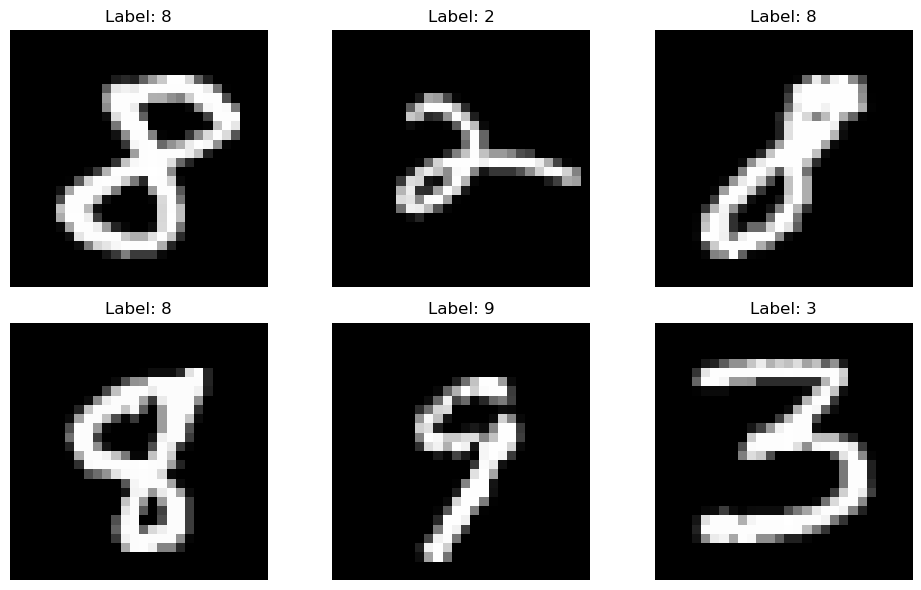

In [8]:
import matplotlib.pyplot as plt

print("sample of training data")
# Plot a few sample images from the training set
plt.figure(figsize=(10, 6))
for images, labels in train_loader:
    # Loop through the first few images in the batch
    for i in range(6):  # Display the first 6 images
        plt.subplot(2, 3, i + 1)
        # Convert the image to 2D by squeezing the channel dimension
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    break  # Display only the first batch

plt.tight_layout()
plt.show()


In [9]:
inputsize = 784
hiddensize = [256,128,64]
numofclasses = 10
lr = 0.01

In [10]:
import torch
import torch.nn as nn

class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, hidden_sizes, num_of_layers, num_of_classes, batch_norm=True):
        
        super(ConvolutionalNeuralNetwork, self).__init__()

        self.conv_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList() if batch_norm else None

        in_channels = 1  # MNIST input has one channel (grayscale)
        out_channels = 32

        # Build convolutional layers dynamically
        for i in range(num_of_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.conv_layers.append(nn.ReLU())  # ReLU Activation
            self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Pooling Layer

            if batch_norm:
                self.batch_norm_layers.append(nn.BatchNorm2d(out_channels))  # Batch Normalization

            in_channels = out_channels
            out_channels *= 2  # Double the number of filters for the next layer

        # Dynamically compute flattened size after convolutional layers
        self.flattened_size = self._get_flattened_size(in_channels // 2, num_of_layers)

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        prev_size = self.flattened_size
        for size in hidden_sizes:
            self.fc_layers.append(nn.Linear(prev_size, size))
            self.fc_layers.append(nn.ReLU())  # ReLU Activation
            prev_size = size

        # Final output layer
        self.fc_layers.append(nn.Linear(prev_size, num_of_classes))

    def _get_flattened_size(self, in_channels, num_conv_layers):
        """
        Compute the flattened size dynamically after convolutional layers.
        """
        dummy_input = torch.zeros(1, 1, 28, 28)  # MNIST input size
        with torch.no_grad():
            for i, layer in enumerate(self.conv_layers):
                dummy_input = layer(dummy_input)
        return dummy_input.numel()

    def forward(self, x):
        # Pass through convolutional layers
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            if isinstance(layer, nn.MaxPool2d) and self.batch_norm_layers:
                x = self.batch_norm_layers[i // 3](x)  # Apply batch normalization after pooling

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        for layer in self.fc_layers:
            x = layer(x)

        return x


In [13]:
model = ConvolutionalNeuralNetwork(hiddensize,3,numofclasses,batch_norm=True)

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr)
lossfunction = nn.CrossEntropyLoss()

In [15]:
#training loop
def train_model(model, train_loader, val_loader, epochs, learning_rate):
    optimizer = torch.optim.SGD(model.parameters(), lr)
    lossfunction = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct_train = 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = lossfunction(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()

        # Validation
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += lossfunction(outputs, labels).item()
                correct_val += (outputs.argmax(dim=1) == labels).sum().item()

        # Store metrics
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(correct_train / len(train_loader.dataset))
        val_accuracies.append(correct_val / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, "
              f"Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")
        

    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    learning_rate=lr
)



Epoch 1/20: Train Loss=0.9556, Val Loss=0.1182, Train Acc=0.7550, Val Acc=0.9691
Epoch 2/20: Train Loss=0.0831, Val Loss=0.0655, Train Acc=0.9771, Val Acc=0.9822
Epoch 3/20: Train Loss=0.0493, Val Loss=0.0533, Train Acc=0.9861, Val Acc=0.9843
Epoch 4/20: Train Loss=0.0347, Val Loss=0.0464, Train Acc=0.9906, Val Acc=0.9866
Epoch 5/20: Train Loss=0.0253, Val Loss=0.0450, Train Acc=0.9931, Val Acc=0.9858
Epoch 6/20: Train Loss=0.0196, Val Loss=0.0417, Train Acc=0.9950, Val Acc=0.9868
Epoch 7/20: Train Loss=0.0143, Val Loss=0.0395, Train Acc=0.9971, Val Acc=0.9882
Epoch 8/20: Train Loss=0.0107, Val Loss=0.0385, Train Acc=0.9982, Val Acc=0.9895
Epoch 9/20: Train Loss=0.0083, Val Loss=0.0407, Train Acc=0.9989, Val Acc=0.9888
Epoch 10/20: Train Loss=0.0061, Val Loss=0.0387, Train Acc=0.9993, Val Acc=0.9890
Epoch 11/20: Train Loss=0.0047, Val Loss=0.0395, Train Acc=0.9997, Val Acc=0.9889
Epoch 12/20: Train Loss=0.0037, Val Loss=0.0403, Train Acc=0.9998, Val Acc=0.9891
Epoch 13/20: Train Loss=0

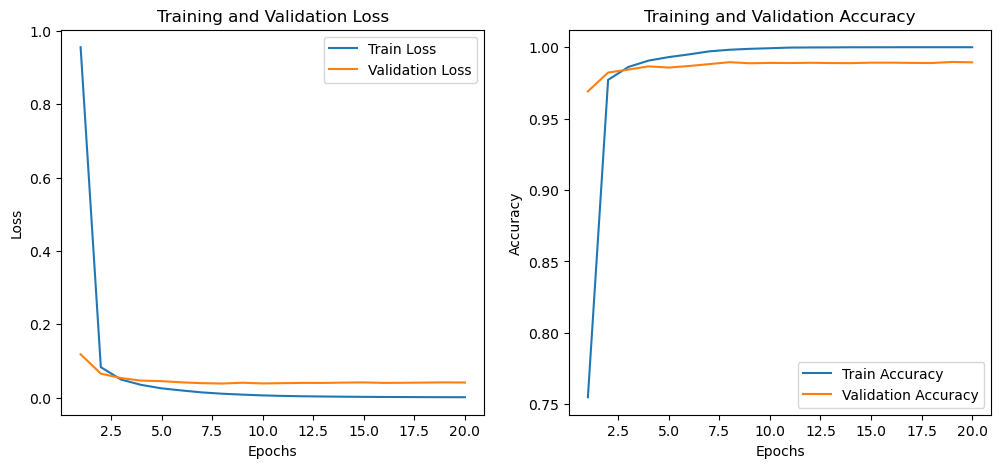

In [17]:
epochs = range(1, len(train_losses) + 1)

# Loss plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.show()

In [18]:
def test_model(model, test_loader, loss_fn):
    model.eval()
    correct_test, total_test, test_loss = 0, 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    accuracy = (correct_test / total_test)*100
    print(f"Test Accuracy: {accuracy:}")
    return accuracy, y_true, y_pred
    

In [19]:
test_model(model, test_loader, lossfunction)

Test Accuracy: 99.1


(99.1,
 [7,
  2,
  1,
  0,
  4,
  1,
  4,
  9,
  5,
  9,
  0,
  6,
  9,
  0,
  1,
  5,
  9,
  7,
  3,
  4,
  9,
  6,
  6,
  5,
  4,
  0,
  7,
  4,
  0,
  1,
  3,
  1,
  3,
  4,
  7,
  2,
  7,
  1,
  2,
  1,
  1,
  7,
  4,
  2,
  3,
  5,
  1,
  2,
  4,
  4,
  6,
  3,
  5,
  5,
  6,
  0,
  4,
  1,
  9,
  5,
  7,
  8,
  9,
  3,
  7,
  4,
  6,
  4,
  3,
  0,
  7,
  0,
  2,
  9,
  1,
  7,
  3,
  2,
  9,
  7,
  7,
  6,
  2,
  7,
  8,
  4,
  7,
  3,
  6,
  1,
  3,
  6,
  9,
  3,
  1,
  4,
  1,
  7,
  6,
  9,
  6,
  0,
  5,
  4,
  9,
  9,
  2,
  1,
  9,
  4,
  8,
  7,
  3,
  9,
  7,
  4,
  4,
  4,
  9,
  2,
  5,
  4,
  7,
  6,
  7,
  9,
  0,
  5,
  8,
  5,
  6,
  6,
  5,
  7,
  8,
  1,
  0,
  1,
  6,
  4,
  6,
  7,
  3,
  1,
  7,
  1,
  8,
  2,
  0,
  2,
  9,
  9,
  5,
  5,
  1,
  5,
  6,
  0,
  3,
  4,
  4,
  6,
  5,
  4,
  6,
  5,
  4,
  5,
  1,
  4,
  4,
  7,
  2,
  3,
  2,
  7,
  1,
  8,
  1,
  8,
  1,
  8,
  5,
  0,
  8,
  9,
  2,
  5,
  0,
  1,
  1,
  1,
  0,
  9,
  0,
  3,
  1,
  6,
  4


Learning Rate: 0.02
Epoch 1/10: Train Loss=0.5604, Val Loss=0.0740, Train Acc=0.8390, Val Acc=0.9789
Epoch 2/10: Train Loss=0.0536, Val Loss=0.0471, Train Acc=0.9837, Val Acc=0.9863
Epoch 3/10: Train Loss=0.0325, Val Loss=0.0417, Train Acc=0.9901, Val Acc=0.9877
Epoch 4/10: Train Loss=0.0213, Val Loss=0.0381, Train Acc=0.9940, Val Acc=0.9890
Epoch 5/10: Train Loss=0.0132, Val Loss=0.0369, Train Acc=0.9967, Val Acc=0.9898
Epoch 6/10: Train Loss=0.0085, Val Loss=0.0336, Train Acc=0.9984, Val Acc=0.9908
Epoch 7/10: Train Loss=0.0053, Val Loss=0.0344, Train Acc=0.9992, Val Acc=0.9909
Epoch 8/10: Train Loss=0.0032, Val Loss=0.0335, Train Acc=0.9998, Val Acc=0.9909
Epoch 9/10: Train Loss=0.0024, Val Loss=0.0332, Train Acc=0.9999, Val Acc=0.9910
Epoch 10/10: Train Loss=0.0017, Val Loss=0.0344, Train Acc=1.0000, Val Acc=0.9908

Learning Rate: 0.1
Epoch 1/10: Train Loss=0.1850, Val Loss=0.0704, Train Acc=0.9440, Val Acc=0.9778
Epoch 2/10: Train Loss=0.0300, Val Loss=0.0393, Train Acc=0.9905, V

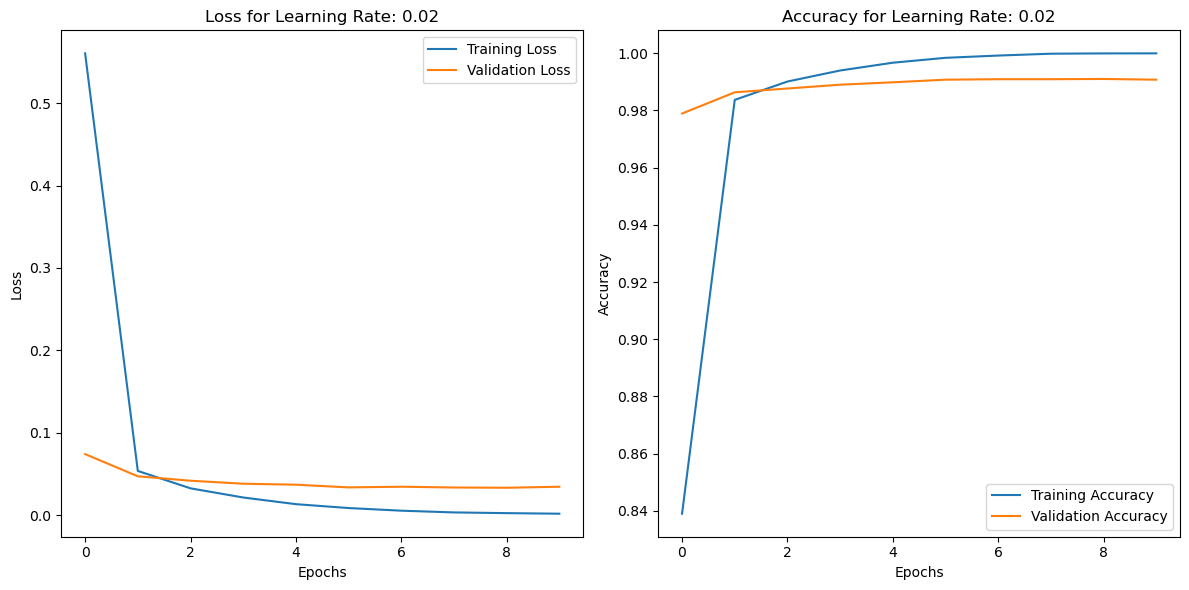

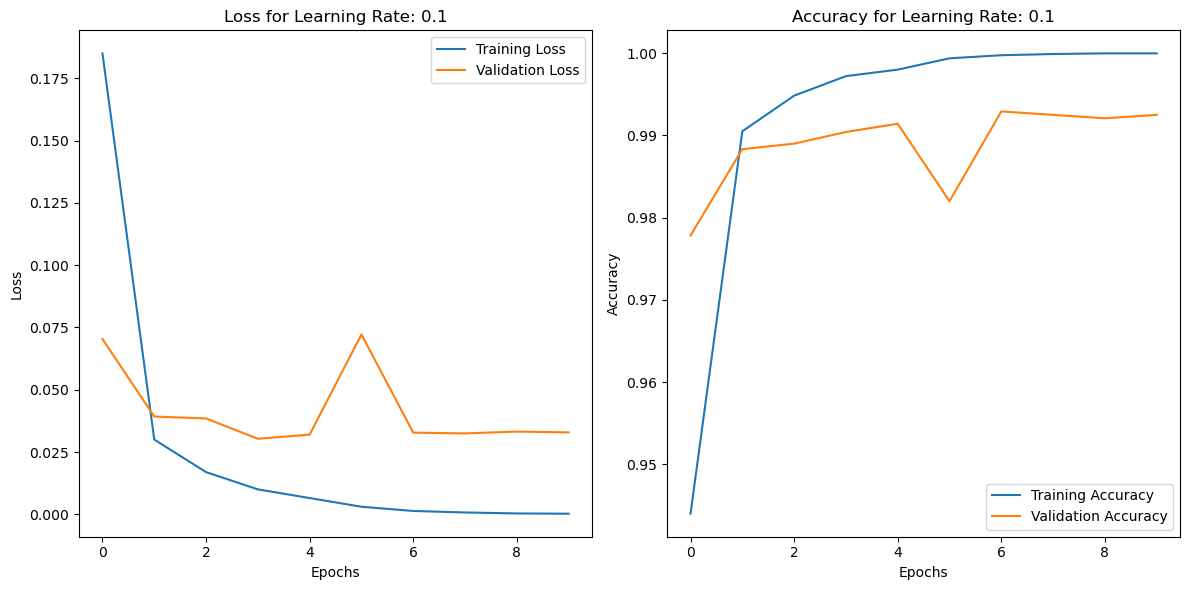

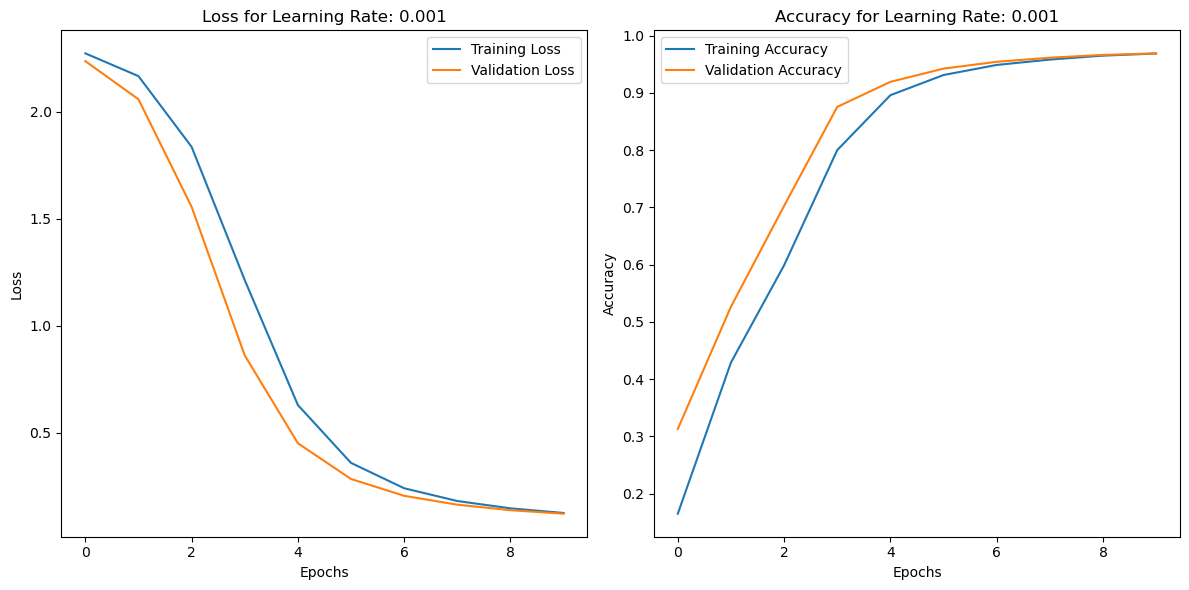

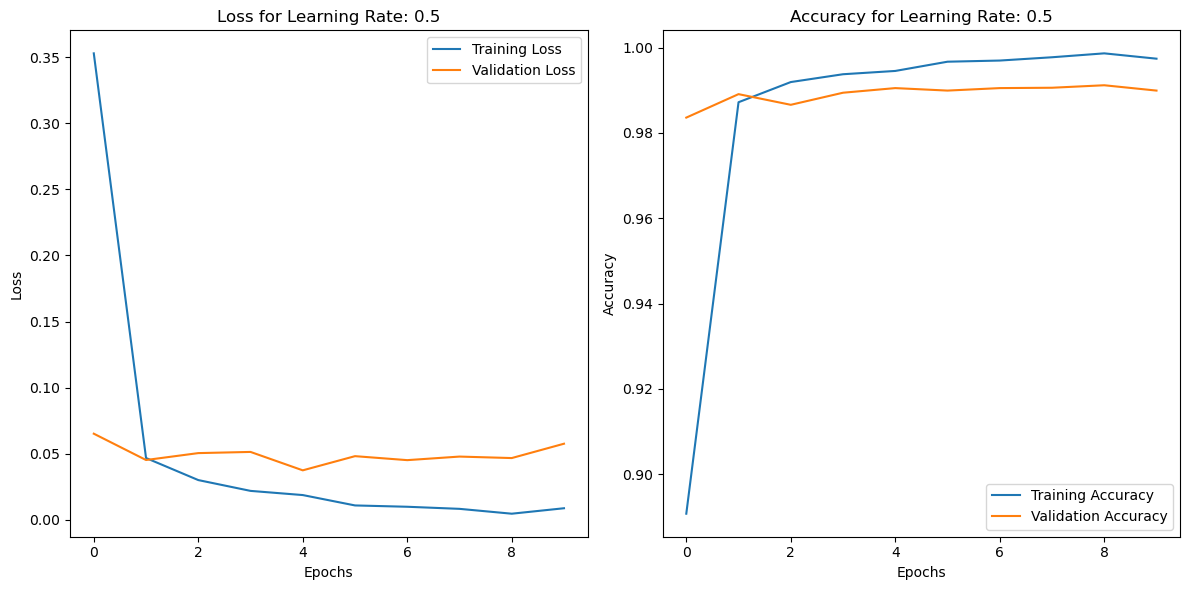

In [23]:

learning_rates = [0.02, 0.1, 0.001, 0.5]
best_lr = None
best_val_acc = 0.0
best_model = None

# Dictionary to store training/validation metrics for each learning rate
metrics = {}

for lr in learning_rates:
    # Initialize the model, loss function, and optimizer
    model = ConvolutionalNeuralNetwork(hiddensize,3,numofclasses,batch_norm=True)
    lossfunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    print(f"\nLearning Rate: {lr}")
    
    # Train and validate the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, epochs=10, learning_rate=lr
    )
    
    # Store for plotting
    metrics[lr] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }
    
    # Get the validation accuracy for the last epoch
    val_acc = val_accuracies[-1]
    
    # Save the best model and learning rate in memory
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_lr = lr
        best_model = model  # Keep the best model in memory

print(f"\nBest Learning Rate: {best_lr}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plot training and validation losses/accuracies for each learning rate
for lr in learning_rates:
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics[lr]["train_losses"], label="Training Loss")
    plt.plot(metrics[lr]["val_losses"], label="Validation Loss")
    plt.title(f"Loss for Learning Rate: {lr}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics[lr]["train_accuracies"], label="Training Accuracy")
    plt.plot(metrics[lr]["val_accuracies"], label="Validation Accuracy")
    plt.title(f"Accuracy for Learning Rate: {lr}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()




Batch Size: 16
Epoch 1/10: Train Loss=2.3587, Val Loss=2.3107, Train Acc=0.1056, Val Acc=0.0973
Epoch 2/10: Train Loss=2.3086, Val Loss=2.3040, Train Acc=0.1046, Val Acc=0.1123
Epoch 3/10: Train Loss=2.3091, Val Loss=2.3060, Train Acc=0.1038, Val Acc=0.1123
Epoch 4/10: Train Loss=2.3081, Val Loss=2.3125, Train Acc=0.1053, Val Acc=0.0975
Epoch 5/10: Train Loss=2.3088, Val Loss=2.3051, Train Acc=0.1036, Val Acc=0.1022
Epoch 6/10: Train Loss=2.3085, Val Loss=2.3177, Train Acc=0.1020, Val Acc=0.1123
Epoch 7/10: Train Loss=2.3087, Val Loss=2.3053, Train Acc=0.1042, Val Acc=0.1123
Epoch 8/10: Train Loss=2.3082, Val Loss=2.3134, Train Acc=0.1061, Val Acc=0.0988
Epoch 9/10: Train Loss=2.3087, Val Loss=2.3066, Train Acc=0.1044, Val Acc=0.1123
Epoch 10/10: Train Loss=2.3087, Val Loss=2.3106, Train Acc=0.1056, Val Acc=0.1044

Batch Size: 32
Epoch 1/10: Train Loss=0.3315, Val Loss=0.0880, Train Acc=0.9059, Val Acc=0.9802
Epoch 2/10: Train Loss=0.1004, Val Loss=0.0609, Train Acc=0.9775, Val Acc=0.

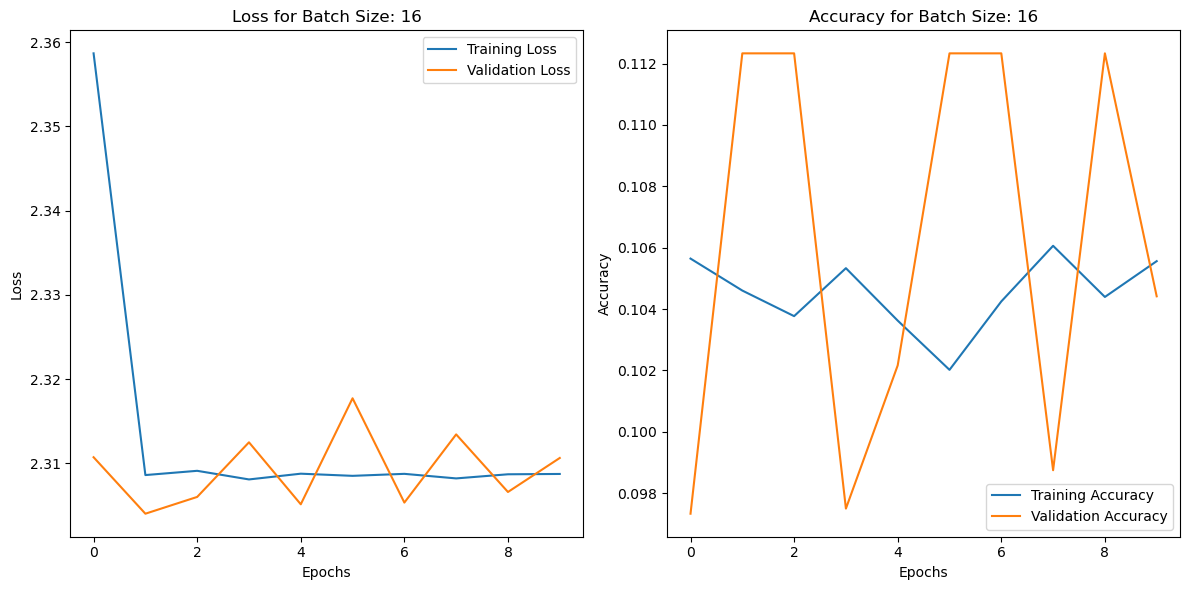

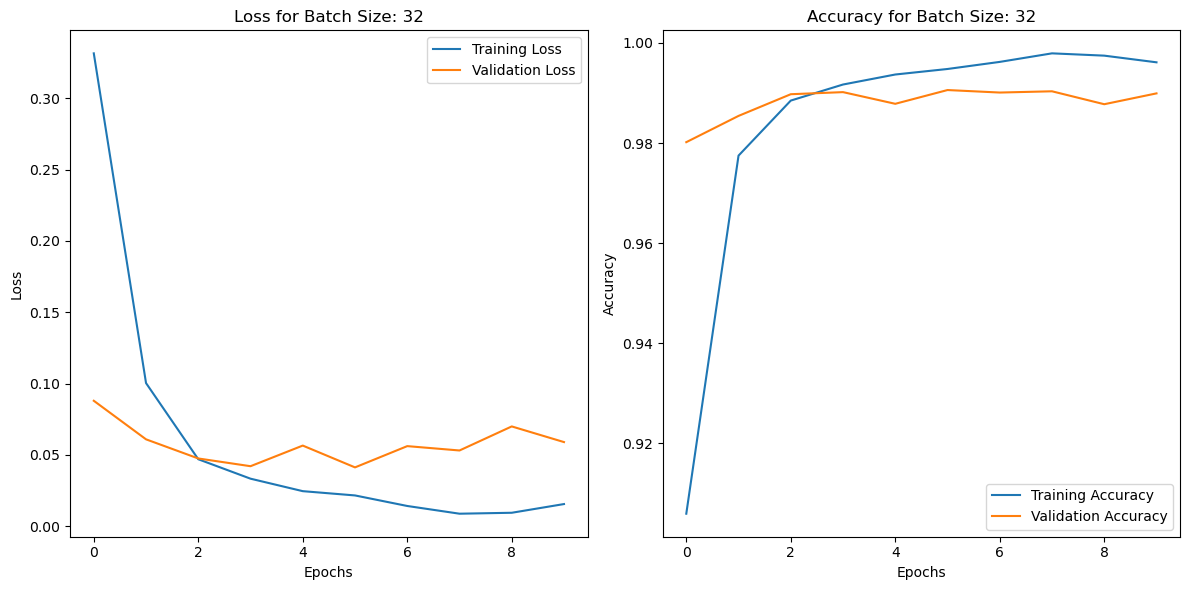

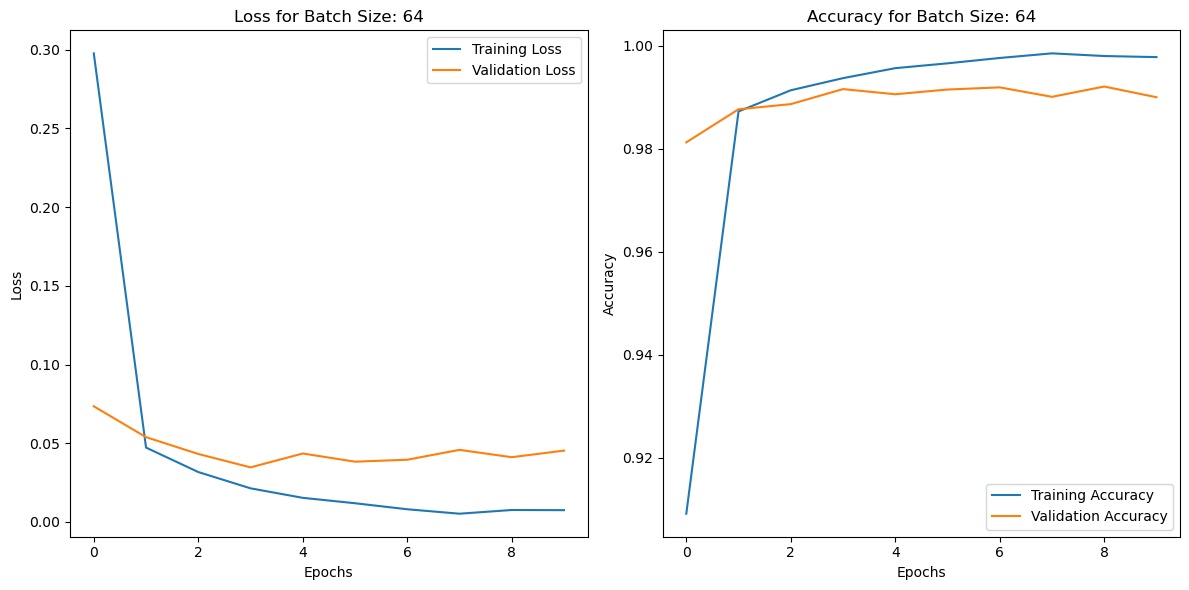

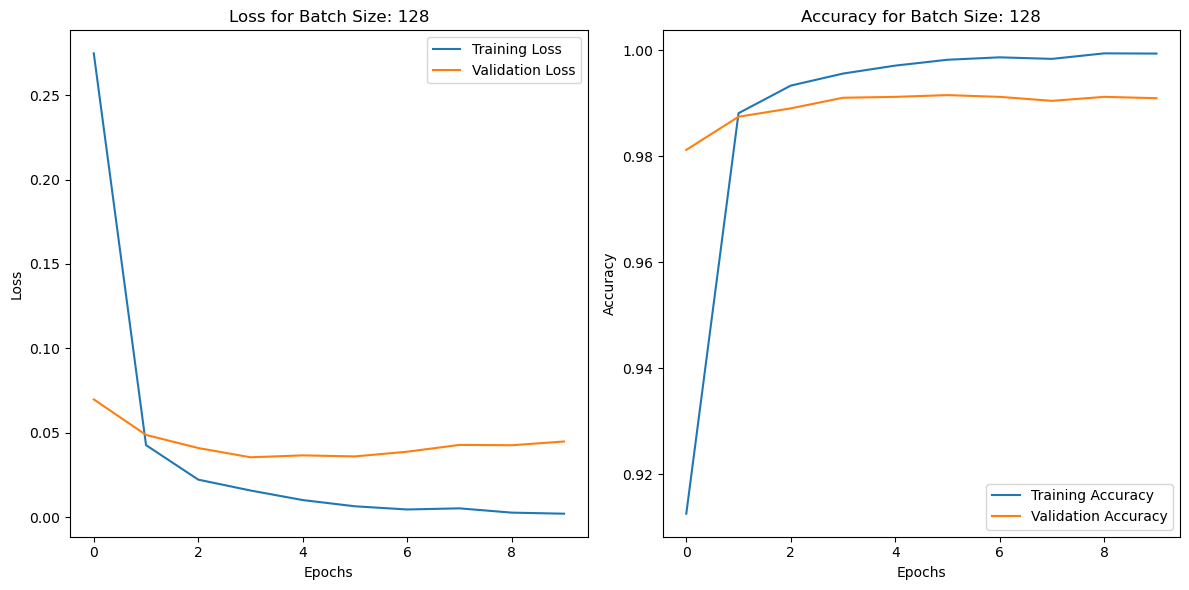

In [24]:
batch_sizes = [16, 32, 64, 128]  # Define batch sizes to test
best_batch_size = None
best_val_acc = 0.0
best_model = None

# Dictionary to store training/validation metrics for each batch size
metrics_batch_size = {}

for batch_size in batch_sizes:
    # Update the data loaders with the current batch size
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # Initialize the model, loss function, and optimizer
    model  = ConvolutionalNeuralNetwork(hiddensize,3,numofclasses,batch_norm=True)
    lossfunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate for comparison
    
    print(f"\nBatch Size: {batch_size}")
    
    # Train and validate the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, epochs=10, learning_rate=0.01
    )
    
    # Store metrics for later plotting
    metrics_batch_size[batch_size] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }
    
    # Get the validation accuracy for the last epoch
    val_acc = val_accuracies[-1]
    
    # Save the best model and batch size in memory
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch_size = batch_size
        best_model = model  # Keep the best model in memory

print(f"\nBest Batch Size: {best_batch_size}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plot training and validation losses/accuracies for each batch size
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics_batch_size[batch_size]["train_losses"], label="Training Loss")
    plt.plot(metrics_batch_size[batch_size]["val_losses"], label="Validation Loss")
    plt.title(f"Loss for Batch Size: {batch_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics_batch_size[batch_size]["train_accuracies"], label="Training Accuracy")
    plt.plot(metrics_batch_size[batch_size]["val_accuracies"], label="Validation Accuracy")
    plt.title(f"Accuracy for Batch Size: {batch_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [25]:
#best model
besthidden = [512, 256, 128, 64]
bestmodel = ConvolutionalNeuralNetwork(besthidden ,4,numofclasses,batch_norm=True)


In [26]:
best_train_loader=torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
best_val_loader=torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
best_test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=bestmodel,
    train_loader=best_train_loader,
    val_loader=best_val_loader,
    epochs=20,
    learning_rate=best_lr
)

Epoch 1/20: Train Loss=0.4408, Val Loss=0.0591, Train Acc=0.8534, Val Acc=0.9833
Epoch 2/20: Train Loss=0.0429, Val Loss=0.0443, Train Acc=0.9886, Val Acc=0.9878
Epoch 3/20: Train Loss=0.0240, Val Loss=0.0406, Train Acc=0.9932, Val Acc=0.9892
Epoch 4/20: Train Loss=0.0179, Val Loss=0.0358, Train Acc=0.9948, Val Acc=0.9897
Epoch 5/20: Train Loss=0.0146, Val Loss=0.0330, Train Acc=0.9959, Val Acc=0.9911
Epoch 6/20: Train Loss=0.0101, Val Loss=0.0349, Train Acc=0.9973, Val Acc=0.9918
Epoch 7/20: Train Loss=0.0089, Val Loss=0.0336, Train Acc=0.9972, Val Acc=0.9924
Epoch 8/20: Train Loss=0.0072, Val Loss=0.0391, Train Acc=0.9978, Val Acc=0.9915
Epoch 9/20: Train Loss=0.0045, Val Loss=0.0343, Train Acc=0.9987, Val Acc=0.9926
Epoch 10/20: Train Loss=0.0043, Val Loss=0.0430, Train Acc=0.9986, Val Acc=0.9910
Epoch 11/20: Train Loss=0.0046, Val Loss=0.0419, Train Acc=0.9988, Val Acc=0.9912
Epoch 12/20: Train Loss=0.0051, Val Loss=0.0468, Train Acc=0.9984, Val Acc=0.9906
Epoch 13/20: Train Loss=0

Test Accuracy: 99.22


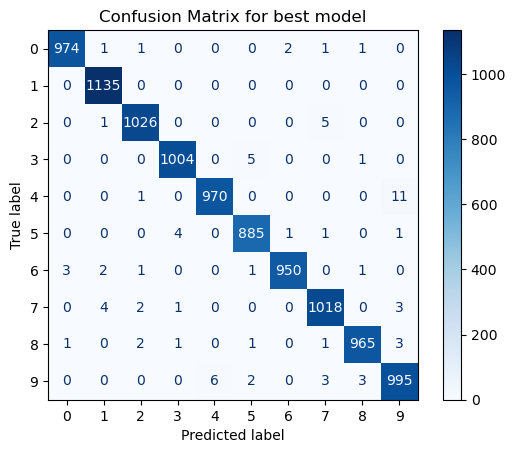

In [28]:
# Use the best model for testing or further evaluation
best_test_accuracy, best_y_true, best_y_pred = test_model(bestmodel, best_test_loader, lossfunction)
confmatrix = confusion_matrix(best_y_true, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confmatrix, display_labels=range(numofclasses))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for best model")
plt.show()